<a href="https://colab.research.google.com/github/Ogunfool/Prognostics-Strategies-An-Aero-engine-Use-case/blob/main/Health_Index_Prediction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the "A_Residual_Similarity_Based_Method_for_Remaining_Useful_Life_Prediction_Using_Degradation_Degree" notebook, we showed that a more sophisticated model can be used to improve the accuracy of the RUL estimator model. So in this notebook, different deep learning models are used for the HI prediction with the aim of achieving better results.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras import losses, optimizers, layers, activations, regularizers
from keras.layers import Dense, Conv1D, LSTM, GRU, Input, Concatenate, MaxPool1D, Flatten, GlobalMaxPool1D
from keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy, mean_squared_error

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, SGD
from keras.metrics import Accuracy, Recall, MeanSquaredError, MeanAbsolutePercentageError
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
# Next, we'll confirm that we can connect to the GPU with tensorflow:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Helper Functions


In [ ]:
np.set_printoptions(suppress=True, linewidth=100, precision=2)

In [ ]:
# Checkpoints - List and npy files
# np.save() - Saves a single array in a binary numpy format
def checkpoints(filename, checkpoint_data):
  np.save(filename, checkpoint_data)
  checkpoint_variable = np.load(filename + '.npy') #Load so that we always have an on-hand version of the checkpoint
  return(checkpoint_variable)

# List Checkpoint
def list_checkpoints(filename, checkpoint_data):
  np.save(filename, checkpoint_data, allow_pickle=True)
  checkpoint_variable = np.load(filename + '.npy', allow_pickle=True) #Load so that we always have an on-hand version of the checkpoint
  return(checkpoint_variable)

Load Data

In [ ]:
# Load normalized_train_data_list and normalized_unwrap_train_data
from google.colab import files
uploaded = files.upload()

Saving HIval-dfr to HIval-dfr
Saving HItrain-dfr to HItrain-dfr


In [ ]:
new_model = tf.keras.models.load_model('/content/best_model_CNN.h5')

In [ ]:
x_train = np.load('/content/x-train.npy')
y_train = np.load('/content/y-train.npy')
x_val = np.load('/content/x-val.npy')
y_val = np.load('/content/y-val.npy')

# Data Preparation.

Use a moving window to convert 2d data to 3D to capture the local relationship or auto-correlation in timeseries data.

In [ ]:
T = 5
new_len = x_train.shape[0] - (T-1)
fake_col = np.zeros((new_len,T))  # Not the same lenght as the actual data
# make single output supervised dataset
for d in range(x_train.shape[1]):
  X = []
  series = x_train[:,d]
  for t in range(len(series) - T + 1):
    x = series[t:t+T]
    X.append(x)

  X = np.array(X).reshape(-1, T)

  # Concatenate Features (TD)
  new_data = np.concatenate((fake_col, X), axis=1)
  fake_col = new_data

X.shape

(41452, 5)

In [ ]:
NT_X_train = new_data[:,T:]
NT_Y_train = y_train[-new_len:]
print(NT_X_train.shape, NT_Y_train.shape)

(41452, 40) (41452,)


In [ ]:
NT_X_val = new_data[:,T:]
NT_Y_val = y_val[-new_len:]
print(NT_X_val.shape, NT_Y_val.shape)

(12299, 40) (12299,)


In [ ]:
# Checkpoints
# Save new x-train, y-train, x-val, y-val
checkpoint_NT_X_train = checkpoints('NT-X-train', NT_X_train)
checkpoint_NT_Y_train = checkpoints('NT-Y-train', NT_Y_train)
checkpoint_NT_X_val = checkpoints('NT-X-val', NT_X_val)
checkpoint_NT_Y_val = checkpoints('NT-Y-val', NT_Y_val)

Prepare data as NxTxD

In [ ]:
array_list = []
for dt in NT_X_val:  # Loop through datapoints
  data_list = []
  for i in range(8):   # Loop through feature size
    data = dt[(i*T):(i*T+T)]
    data_list.append(data)
  one_dpoint = np.array(list(zip(data_list)))
  array_list.append(one_dpoint.reshape(-1,T).T)

len(array_list)

12299

In [ ]:
NTD_X_train = np.array(array_list)

In [ ]:
NTD_X_val = np.array(array_list)

In [ ]:
NTD_X_train_list = array_list

In [ ]:
NTD_X_val_list = array_list

In [ ]:
# Checkpoints
checkpoint_NTD_X_train = checkpoints('NTD-X-train', NTD_X_train)
checkpoint_NTD_X_val = checkpoints('NTD-X-val', NTD_X_val)

In [ ]:
# Use lists checkpoint instead
checkpoint_NTD_X_train_list = list_checkpoints('NTD-X-train-list', NTD_X_train_list)
checkpoint_NTD_X_val_list = list_checkpoints('NTD-X-val-list', NTD_X_val_list)

In [ ]:
print(NT_X_train.shape, NT_Y_train.shape, NT_X_val.shape, NT_Y_val.shape, NTD_X_train.shape, NTD_X_val.shape)

(41452, 40) (41452,) (12299, 40) (12299,) (41452, 5, 8) (12299, 5, 8)


In [ ]:
# Save files as csv
np.savetxt('NT-X-train.csv', NT_X_train, fmt='%.18e', delimiter=',')
np.savetxt('NT-X-val.csv', NT_X_val, fmt='%.18e', delimiter=',')
np.savetxt('NT-Y-train.csv', NT_Y_train, fmt='%.18e', delimiter=',')
np.savetxt('NT-Y-val.csv', NT_Y_val, fmt='%.18e', delimiter=',')

Model Building Helper Functions.

In [ ]:
# Let's create some helper functions for the training process (We are trying to select a model so, many models will be trained and they have similar execution configurations)
# Learning Rate Scheduler:
def lr_scheduler(STEPS_PER_EPOCH):
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False)
  return lr_schedule

def get_optimizer(scheduler=None):
  if scheduler is None:
    return tf.keras.optimizers.Adam(learning_rate=0.001)
  return tf.keras.optimizers.Adam(lr_scheduler())

# Compile and fit
def compile(model, optimizer=None, scheduler=None,  loss=None, max_epochs=1000, STEPS_PER_EPOCH=1000):
  if optimizer is None:    # that is, i want to set Adam optimizer & learning rate to 0.001 by default or use a lr_scheduler function
    optimizer = get_optimizer()
  else:
    optimizer = optimizer

  if loss is None:
    loss = 'mse'
  else:
    loss = loss

  model.compile(optimizer=optimizer, loss=loss)

  return model


Plots Helper Functions

In [ ]:
# Helper function that plots, saves and shows plots
def plot_loss_accuracy(filename):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.savefig(filename + '.png')
  plt.show()

# Finding the baseline model.

A baseline model is a good starting point. Based on the data shapes, different models were tried and are still been tried to achieve very high results. The models used can be grouped based on the data shape.

1. Model 1: A classic feedforward network with NxD data.
2. NxTD data: Feedforward NN, Multi-tail ANN, CNN and LSTM.
1. NxTxD (3D) data: CNN, LSTM.
1. Window sizes [3,5,10] were tried. window size 5 had gave best results.
2. Note: These models were implemented quickly (i.e. so much attention wasn't paid to tuning the hyperparameters at first) because the aim is to find a good enoug model that will ten be throughly tuned. Different data shapes were also tried to do a quick exhaustive search and analysis to make informed decisions. 





In [ ]:
T = 5
D = 8
K = 1

Fully Connected ANN Model with NxD dataset.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Fully Connected NN
FC_ANN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(D,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(K)
])

In [ ]:
FC_ANN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                288       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.keras.backend.clear_session()

model = FC_ANN
model = compile(model)
check_point = ModelCheckpoint(
    'best_model_FC_ANN_NR.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=200)

history = model.fit(x_train, y_train, epochs=1000, 
                    validation_data=(x_val, y_val),
                    callbacks=[check_point, early_stopping],
                    verbose=2)

# Load best model
best_model = tf.keras.models.load_model('best_model_FC_ANN.h5')

# Make predictions with best model 
y_pred = best_model.predict(x_val)

# Evaluate with best model
val_loss = best_model.evaluate(x_val, y_val)

In [ ]:
best_model.evaluate(x_val, y_val)

385/385 [==============================] - 1s 2ms/step - loss: 0.0231


0.023127106949687004

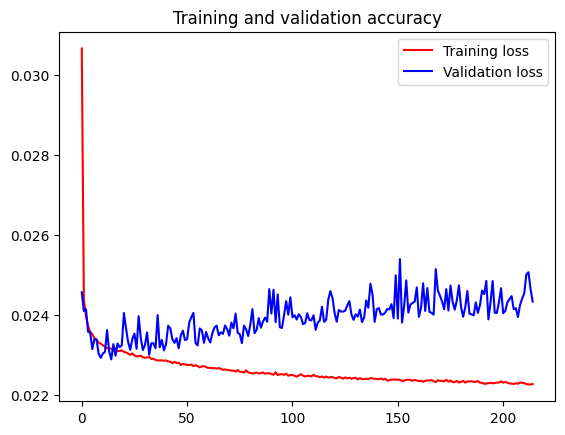

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_loss_accuracy(filename='ANN for health index prediction')

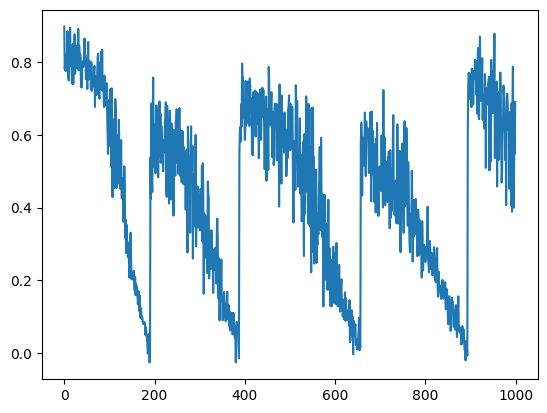

In [ ]:
plt.plot(y_pred.flatten()[:1000]);

In [ ]:
# Check R2-score
r2_score(y_val, y_pred)

0.7251691563138285

In [ ]:
y_train_pred = best_model.predict(x_train)

Nx(TD) for fully connected NN.

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# FC_ANN
model_FCN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(T*D,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(K)
])

In [ ]:
model_FCN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1296      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,441
Trainable params: 1,441
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = model_FCN
model = compile(model)
check_point = ModelCheckpoint(
    'best_model_FCN.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=200)

history = model.fit(NT_x_train, NT_y_train, epochs=1000, 
                    validation_data=(NT_x_val, NT_y_val),
                    callbacks=[check_point, early_stopping],
                    verbose=2)

# Load best model
best_model = tf.keras.models.load_model('best_model_FCN.h5')

# Make predictions with best model 
y_pred = best_model.predict(NT_x_val)

# Evaluate with best model
val_loss = best_model.evaluate(NT_x_val, NT_y_val)

In [ ]:
val_loss

0.14104200899600983

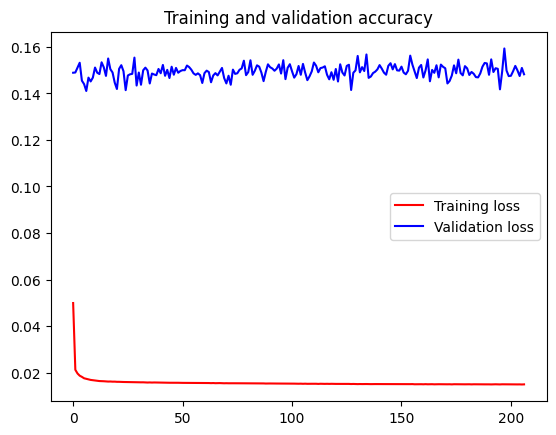

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_loss_accuracy(filename='ANN for health index prediction')

Comment: Observation from this method shows the effect of too many features influenced majorly by the dimensions of the input data and the model type. Fully connected NN's don't have the weight sharing capability like CNNs and RNNs so they can easily overfit. 

# Use Prepared dataset NxTxD to train Multi-tail-ANN, CNN and LSTM networks

In [ ]:
T = 10
D = 8
K = 1

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# The ANN Model development - Multi-Input/Multi-tail ANN
# You have to keep track of the input and the output of the model
inputs = []
features = []

# Build a dense ANN model for each feature - 
# If you use the input layers in a for loop, different unique instances of the symbolic tensors are automatically created - So they can have their unique function flow
for _ in range(D):
  i = Input(shape=(T,))
  x = Dense(5, activation='relu')(i)
  inputs.append(i)
  features.append(x)

# recall, we want to concatenate the outputs of the multi-unit ANN models
# N x (FxD)
x = Concatenate()(features)
# Now start working on this
x = Dense(16, activation='relu')(x)
x = Dense(K)(x)

# Instantiate Model
model_ANN = Model(inputs, x)

In [ ]:
x_trains = []
for k in range(D):
  l = NT_x_train[:,k*10:k*10+10]
  x_trains.append(l)
len(x_trains)

8

In [ ]:
x_trains[0].shape

(41447, 10)

In [ ]:
x_vals = []
for k in range(D):
  l = NT_x_val[:,k*10:k*10+10]
  x_vals.append(l)
len(x_vals)

8

In [ ]:
x_vals[0].shape

(12294, 10)

In [ ]:
model = model_ANN
model = compile(model)
check_point = ModelCheckpoint(
    'best_model_ANN.h5', monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=200)

history = model.fit(x_trains, NT_y_train, epochs=1000, 
                    validation_data=(x_vals, NT_y_val),
                    callbacks=[check_point, early_stopping],
                    verbose=2)

# Load best model
best_model = tf.keras.models.load_model('best_model_ANN.h5')

# Make predictions with best model 
y_pred = best_model.predict(x_vals)

# Evaluate with best model
val_loss = best_model.evaluate(x_vals, y_val)

In [ ]:
val_loss

0.14104200899600983

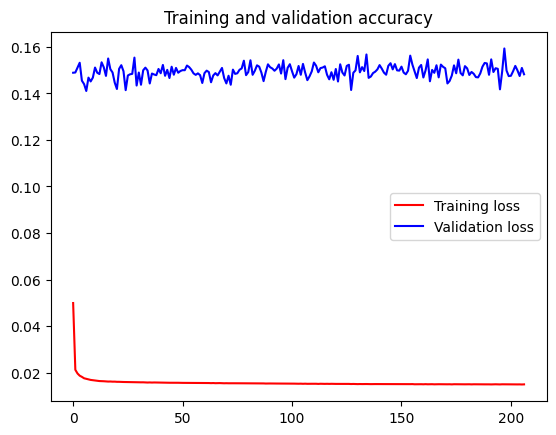

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_loss_accuracy(filename='ANN for health index prediction')

Build CNN and LSTM Models

In [ ]:
# CNN Model - 1D Convnet
model_CNN = tf.keras.Sequential([
  tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(T,D)),
  tf.keras.layers.MaxPooling1D(),
  tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling1D(),
  tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling1D(),
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(K)
])

# LSTM Model
model_LSTM = tf.keras.Sequential([
  tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(T,D)),
  tf.keras.layers.LSTM(24, return_sequences=True),
  tf.keras.layers.LSTM(16),
  tf.keras.layers.Dense(K)  
])

In [ ]:
model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 10, 32)            800       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 5, 32)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 5, 64)             6208      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2, 128)            24704     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)              

Compile, Fit, Plot costs and Evaluate models.

Epoch 1/30
1296/1296 - 7s - loss: 0.0014 - val_loss: 0.1594
Epoch 2/30
1296/1296 - 5s - loss: 0.0014 - val_loss: 0.1615
Epoch 3/30
1296/1296 - 5s - loss: 0.0013 - val_loss: 0.1597
Epoch 4/30
1296/1296 - 6s - loss: 0.0014 - val_loss: 0.1641
Epoch 5/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1628
Epoch 6/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1628
Epoch 7/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1668
Epoch 8/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1584
Epoch 9/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1641
Epoch 10/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1590
Epoch 11/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1626
Epoch 12/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1587
Epoch 13/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1585
Epoch 14/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1645
Epoch 15/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1582
Epoch 16/30
1296/1296 - 6s - loss: 0.0013 - val_loss: 0.1622
Epoch 17/30
1296/1296 - 6s - loss

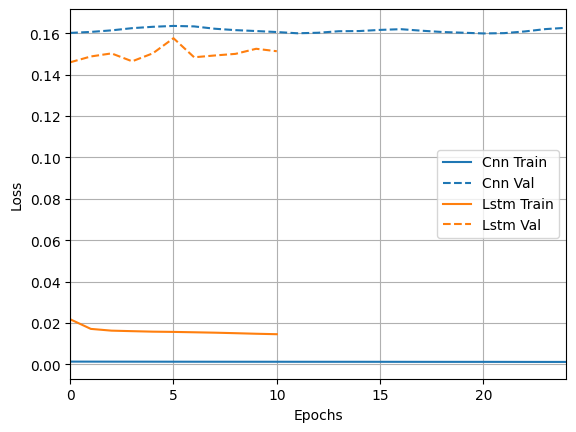

In [ ]:
# CNN and LSTM train
history = {}
y_preds = []
val_losses = []
models = [model_CNN, model_LSTM]
names = ['CNN','LSTM']

for idx, name in enumerate(names):
  # instantiate call backs
  check_point = ModelCheckpoint('best_model_'+name+'.h5', monitor='val_loss', save_best_only=True)
  early_stopping = EarlyStopping(monitor='val_loss', patience=10)

  # Compile Model
  model = compile(models[idx])

  # Fit Model
  history[name] = model.fit(NTD_x_train, NT_y_train, epochs=30, 
                      validation_data=(NTD_x_val, NT_y_val),
                      callbacks=[check_point, early_stopping],
                      verbose=2)
  
  # Get best model from current model
  best_model = tf.keras.models.load_model('best_model_'+name+'.h5')

  # Make predictions with best model 
  y_pred = best_model.predict(NTD_x_val)
  y_preds.append(y_pred)

  # Evaluate with best model
  val_loss = best_model.evaluate(NTD_x_val, NT_y_val)
  val_losses.append(val_loss)

  tf.keras.backend.clear_session()

# Plot metric
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(history)


In [ ]:
val_losses

[0.15819191932678223, 0.14574983716011047]

In [ ]:
y_preds[0].shape

(12294, 1)

Thoughts and comments on above models.


*   ANN + orig_data: This had the best result initially but after much tuning, it shows that there is so much the fully connected ANN can do with this problem. Increasing the layers will just result in more overfitting but not enable the network to learn better. The drastic drop in loss within very few epochs also shows this.

*   ANN + NT_Data: Just as expected, there is so much an ANN can do for this problem and we have too many parameters so the overfit was terrible.
*  Multi-tail ANN + NTD_Data: Acted just like the ANN + NT_Data model.

*   CNN + NTD_Data: This is particularly interesting, eventhough there was tremendous overfitting due to too many parameters, the train loss was much lower than we got with ANN and multi-tail ANN. This shows than CNN has the capacity to extract better features from the data if it is trained and finetuned properly.


*   LSTM + NTD_Data: Surprisingly, LSTM doesn't do much better than ANN.





# Training and Finetuning Selected Baseline Models for better performance. 

Fully Connected ANN Model with NxD dataset - Add regularization and use keras tuner to tune learning rate, No of activation units and regularization parameter.

Prepare datasets for use in tensorflow - Build data input pipeline.


* If all of your input data fits in memory, the simplest way to create a Dataset from numpy arrays is to convert them to tf.Tensor objects and use Dataset.from_tensor_slices. This returns a tf.data.Dataset that can slice up the dictionary of features. You can iterate over a tf.data.Dataset like any other python iterable.

*   Batch and configure data - Do not shuffle the dataset.
For timeseries data, we want to mantain the order of the data when feeding it to the network.



In [ ]:
# Create a tf Dataset for numpy array and batch
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(BATCH_SIZE) 
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val)).batch(BATCH_SIZE) 

In [ ]:
# ANN Model
def model_builder(hp):
  FC_ANN_R = tf.keras.models.Sequential([
      
      tf.keras.layers.Dense(units=hp.Choice('neurons_1', values=[32, 64, 96]), activation='relu', kernel_initializer='he_uniform',
                            kernel_regularizer=regularizers.L2(hp.Choice('reg_rate1', values=[0.00 , 1e-2 , 3e-3 , 1e-3])), input_shape=(D,)),
      tf.keras.layers.Dense(units=hp.Choice('neurons_2', values=[32, 64, 96]), activation='relu', kernel_initializer='he_uniform',
                            kernel_regularizer=regularizers.L2(hp.Choice('reg_rate2', values=[0.00 , 1e-2 , 3e-3 , 1e-3]))),
      tf.keras.layers.Dense(K)
  ])
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 3e-2, 1e-3, 3e-3])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse')
  return model

In [ ]:
# Use the hyperband tuner
tuner_ANN = kt.Hyperband(model_builder,
                    objective='val_loss',
                    max_epochs=100,
                    factor=3,
                    directory='FC_ANN_R',
                    project_name='NASA_HI'
                    )
tuner_ANN.search_space_summary()

INFO:tensorflow:Reloading Tuner from FC_ANN_R\NASA_HI\tuner0.json
Search space summary
Default search space size: 5
neurons_1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 96], 'ordered': True}
reg_rate1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
neurons_2 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 96], 'ordered': True}
reg_rate2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.01, 0.003, 0.001], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.03, 0.001, 0.003], 'ordered': True}


In [ ]:
# Instantiate callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

# Search - Takes in the same hyperparameters as fit
tuner_ANN.search(train_dataset, epochs=100, validation_data=val_dataset,
                 callbacks=[early_stopping] )

Trial 246 Complete [00h 01m 45s]
val_loss: 0.038887787610292435

Best val_loss So Far: 0.02269602008163929
Total elapsed time: 01h 14m 49s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Shows the 10 best trials
tuner_ANN.results_summary()

In [ ]:
best_hps = tuner_ANN.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
best_hps['reg_rate2']

0.003

In [ ]:
model_ANN = tuner_ANN.hypermodel.build(best_hps)
# Retrain the model
history =  model_ANN.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping])

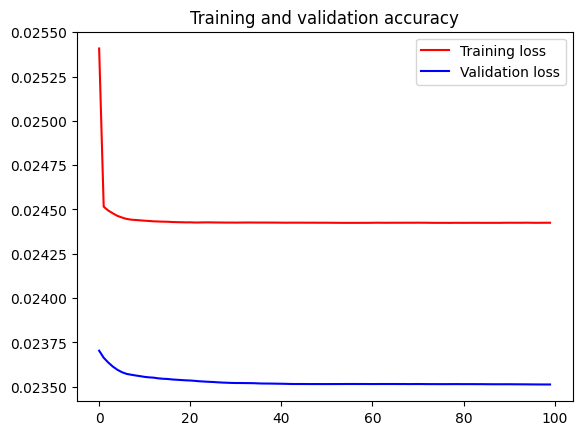

<Figure size 640x480 with 0 Axes>

In [ ]:
# Compile, fit and plot
# history = compile_and_fit(model, optimizer=None, max_epochs=70)
plot_loss_accuracy(filename='ANN + Orig_data')


In [ ]:
# Make predictions with best model 
y_pred = model_ANN.predict(val_dataset)

# Check R2-score on validation set
r2_score(y_val, y_pred)

0.7205925175441565

Comment: It can only fit the data to an r2-score of about 73% and we need something as good as 90-95%.

# CNN + NTD_Data.

In [ ]:
T = 5
D = 8
K = 1

In [ ]:
# CNN Model - 1D Convnet
model_CNN = tf.keras.Sequential([
  tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(T,D)),
  tf.keras.layers.MaxPooling1D(),
  tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
  tf.keras.layers.MaxPooling1D(),
  # tf.keras.layers.Conv1D(128, 3, activation='relu', padding='same'),
  # tf.keras.layers.MaxPooling1D(),
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(K)
])
  

Epoch 1/30
1296/1296 - 10s - loss: 0.0248 - val_loss: 0.0205
Epoch 2/30
1296/1296 - 5s - loss: 0.0197 - val_loss: 0.0201
Epoch 3/30
1296/1296 - 5s - loss: 0.0188 - val_loss: 0.0209
Epoch 4/30
1296/1296 - 5s - loss: 0.0184 - val_loss: 0.0195
Epoch 5/30
1296/1296 - 5s - loss: 0.0181 - val_loss: 0.0195
Epoch 6/30
1296/1296 - 5s - loss: 0.0177 - val_loss: 0.0199
Epoch 7/30
1296/1296 - 5s - loss: 0.0175 - val_loss: 0.0201
Epoch 8/30
1296/1296 - 5s - loss: 0.0173 - val_loss: 0.0196
Epoch 9/30
1296/1296 - 5s - loss: 0.0170 - val_loss: 0.0209
Epoch 10/30
1296/1296 - 5s - loss: 0.0168 - val_loss: 0.0206
Epoch 11/30
1296/1296 - 5s - loss: 0.0166 - val_loss: 0.0206
Epoch 12/30
1296/1296 - 5s - loss: 0.0163 - val_loss: 0.0210
Epoch 13/30
1296/1296 - 5s - loss: 0.0160 - val_loss: 0.0207
Epoch 14/30
1296/1296 - 5s - loss: 0.0157 - val_loss: 0.0211
Epoch 15/30
1296/1296 - 5s - loss: 0.0157 - val_loss: 0.0221
385/385 [==============================] - 1s 2ms/step - loss: 0.0195


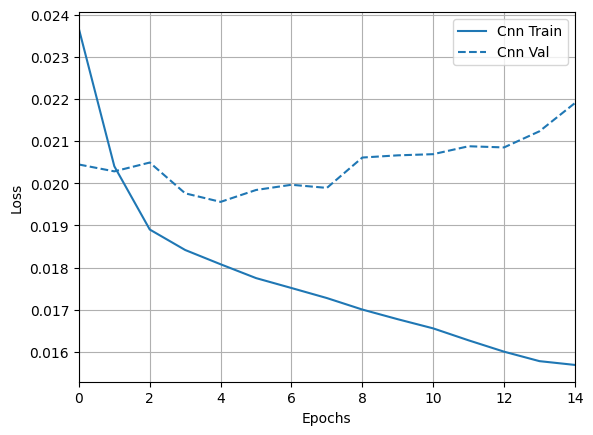

In [ ]:
# CNN and LSTM train
history = {}
y_preds = []
val_losses = []
models = [model_CNN]
names = ['CNN']

for idx, name in enumerate(names):
  # instantiate call backs
  check_point = ModelCheckpoint('best_model_'+name+'.h5', monitor='val_loss', save_best_only=True)
  early_stopping = EarlyStopping(monitor='val_loss', patience=10)

  # Compile Model
  model = compile(models[idx])

  # Fit Model
  history[name] = model.fit(NTD_x_train, NT_y_train, epochs=30, 
                      validation_data=(NTD_x_val, NT_y_val),
                      callbacks=[check_point, early_stopping],
                      verbose=2)
  
  # Get best model from current model
  best_model = tf.keras.models.load_model('best_model_'+name+'.h5')

  # Make predictions with best model 
  y_pred = best_model.predict(NTD_x_val)
  y_preds.append(y_pred)

  # Evaluate with best model
  val_loss = best_model.evaluate(NTD_x_val, NT_y_val)
  val_losses.append(val_loss)

  tf.keras.backend.clear_session()

# Plot metric
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(history)


In [ ]:
# Check R2-score
r2_score(NT_y_val, y_pred)

0.7685044265852198

This model ordinarily results in a better improvement than ANN and  CNN when T = 5. So let's finetue this model further.

In [ ]:
# CNN Model - 1D Convnet
model_CNN = tf.keras.Sequential([
  tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same', input_shape=(T,D), kernel_initializer='he_uniform'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling1D(),
  tf.keras.layers.Dropout(0.4),

  tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_uniform'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling1D(),
  tf.keras.layers.Dropout(0.4),

  # tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_uniform'),
  # tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.MaxPooling1D(),
  # tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),

  # output layer
  tf.keras.layers.Dense(K)
])
  

Epoch 1/30
1296/1296 - 13s - loss: 0.2111 - val_loss: 0.0367
Epoch 2/30
1296/1296 - 12s - loss: 0.0425 - val_loss: 0.0328
Epoch 3/30
1296/1296 - 12s - loss: 0.0342 - val_loss: 0.0251
Epoch 4/30
1296/1296 - 11s - loss: 0.0308 - val_loss: 0.0236
Epoch 5/30
1296/1296 - 13s - loss: 0.0289 - val_loss: 0.0225
Epoch 6/30
1296/1296 - 13s - loss: 0.0273 - val_loss: 0.0210
Epoch 7/30
1296/1296 - 12s - loss: 0.0264 - val_loss: 0.0212
Epoch 8/30
1296/1296 - 12s - loss: 0.0256 - val_loss: 0.0219
Epoch 9/30
1296/1296 - 12s - loss: 0.0252 - val_loss: 0.0208
Epoch 10/30
1296/1296 - 13s - loss: 0.0250 - val_loss: 0.0202
Epoch 11/30
1296/1296 - 13s - loss: 0.0244 - val_loss: 0.0197
Epoch 12/30
1296/1296 - 13s - loss: 0.0243 - val_loss: 0.0204
Epoch 13/30
1296/1296 - 13s - loss: 0.0240 - val_loss: 0.0195
Epoch 14/30
1296/1296 - 13s - loss: 0.0239 - val_loss: 0.0190
Epoch 15/30
1296/1296 - 12s - loss: 0.0241 - val_loss: 0.0202
Epoch 16/30
1296/1296 - 11s - loss: 0.0241 - val_loss: 0.0194
Epoch 17/30
1296/

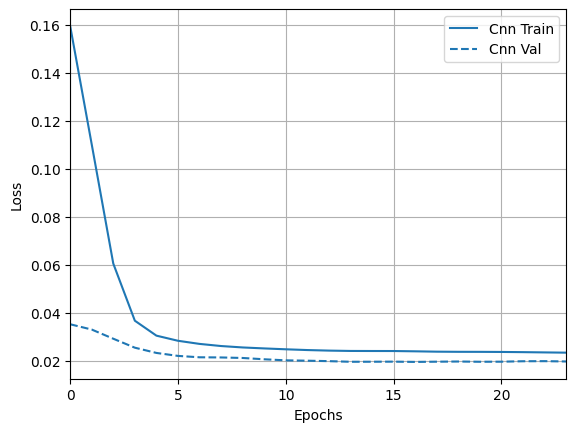

In [ ]:
# CNN and LSTM train
history = {}
y_preds = []
val_losses = []
models = [model_CNN]
names = ['CNN']

for idx, name in enumerate(names):
  # instantiate call backs
  check_point = ModelCheckpoint('best_model_'+name+'.h5', monitor='val_loss', save_best_only=True)
  early_stopping = EarlyStopping(monitor='val_loss', patience=10)

  # Compile Model
  model = compile(models[idx])

  # Fit Model
  history[name] = model.fit(NTD_x_train, NT_y_train, epochs=30, 
                      validation_data=(NTD_x_val, NT_y_val),
                      callbacks=[check_point, early_stopping],
                      verbose=2)
  
  # Get best model from current model
  best_model = tf.keras.models.load_model('best_model_'+name+'.h5')

  # Make predictions with best model 
  y_pred = best_model.predict(NTD_x_val)
  y_preds.append(y_pred)

  # Evaluate with best model
  val_loss = best_model.evaluate(NTD_x_val, NT_y_val)
  val_losses.append(val_loss)

  tf.keras.backend.clear_session()

# Plot metric
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(history)


In [ ]:
# Check R2-score
r2_score(NT_y_val, y_pred)

0.7741314861535076

Tune CNN Model

In [ ]:
# Create a tf Dataset for numpy array and batch
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((NTD_x_train,NT_y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((NTD_x_val,NT_y_val))

In [ ]:
# CNN Model - 1D Convnet
def model_builder(hp):
  model_CNN = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=(hp.Choice('filters1', values=[16,32,64,96,128])), kernel_size=3, activation='relu', padding='same', 
                           input_shape=(T,D,), kernel_initializer='he_uniform'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Dropout(hp.Choice('drop_rate1', values=[0.00 , 0.2 , 0.4 , 0.6, 0.8])),

    tf.keras.layers.Conv1D(filters=(hp.Choice('filters2', values=[16,32,64,96,128])), kernel_size=3, activation='relu', padding='same', 
                           kernel_initializer='he_uniform'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Dropout(hp.Choice('drop_rate2', values=[0.00 , 0.2 , 0.4 , 0.6, 0.8])),

    # tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same', kernel_initializer='he_uniform'),
    # tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.MaxPooling1D(),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(units=(hp.Choice('units1', values=[16,32,64,96,128])), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(hp.Choice('drop_rate2', values=[0.00 , 0.2 , 0.4 , 0.6, 0.8])),

    # output layer
    tf.keras.layers.Dense(K)
  ])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss='mse')

  return model
    

In [ ]:
# Use the hyperband tuner
tuner_CNN = kt.Hyperband(model_builder,
                    objective='val_loss',
                    max_epochs=100,
                    factor=3,
                    directory='CNN',
                    project_name='NASA_HI'
                    )
tuner_CNN.search_space_summary()

INFO:tensorflow:Reloading Tuner from CNN\NASA_HI\tuner0.json
Search space summary
Default search space size: 5
filters1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 96, 128], 'ordered': True}
drop_rate1 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.4, 0.6, 0.8], 'ordered': True}
filters2 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 96, 128], 'ordered': True}
drop_rate2 (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.2, 0.4, 0.6, 0.8], 'ordered': True}
units1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 96, 128], 'ordered': True}


In [ ]:
# Instantiate callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

# Search - Takes in the same hyperparameters as fit
tuner_CNN.search(NTD_x_train, NT_y_train, epochs=100, validation_data=(NTD_x_val, NT_y_val),
                 callbacks=[early_stopping] )

In [ ]:
# Shows the 10 best trials
tuner_CNN.results_summary()

In [ ]:
best_hps = tuner_CNN.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
best_hps['reg_rate2']

In [ ]:
model_ANN = tuner_CNN.hypermodel.build(best_hps)
# Retrain the model
history =  model_CNN.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[early_stopping])

In [ ]:
# Compile, fit and plot
# history = compile_and_fit(model, optimizer=None, max_epochs=70)
plot_loss_accuracy(filename='CNN + Orig_data')


In [ ]:
# Make predictions with best model 
y_pred = model_CNN.predict(val_dataset)

# Check R2-score on validation set
r2_score(y_val, y_pred)

Comments:


*   Note: the keras tuner took about 3 hrs to train, this is a very long time but it was done to be able to see the best result we can get from the CNN model with the 3d data for this dataset. This shows that more sophisticted models is required for this dataset.
*   Keras tuner results are: [filters1, drop_rate1, filters2, drop_rate2, units1] = [16, 32, 64, 0.4, 0.4]

Put Best Model Predictions in dataframe and save.

In [ ]:
best_model = tf.keras.models.load_model('/content/best_model_CNN.h5')

In [ ]:
# Make predictions with best model 
y_pred = best_model.predict(NTD_x_val)

385/385 [==============================] - 9s 2ms/step


In [ ]:
# Check R2-score
r2_score(NT_y_val, y_pred)

0.7741304390759769

In [ ]:
y_pred = best_model.predict(NTD_x_val)
y_train_pred = best_model.predict(NTD_x_train)

1296/1296 [==============================] - 2s 2ms/step


In [ ]:
HItrain_df = pd.read_csv('/content/HItrain-dfr')
HItrain_df.head()

,Unit_id,Time,ori_HI,Maxcycle,RUL,new_HI,apprx_HI,apprx_HI_ANN,HI_PCA,new_HI_PCA
0,1,1,1.000000,149,148,0.582822,0.546977,0.631525,-0.859024,-1.192820
1,1,2,0.993243,149,147,0.582912,0.581504,0.724908,-0.628524,-1.197747
2,1,3,0.986486,149,146,0.582965,0.601732,0.767940,-0.404679,-1.202504
3,1,4,0.979730,149,145,0.583290,0.726264,0.847148,-1.859147,-1.171129
4,1,5,0.972973,149,144,0.582879,0.568990,0.711482,-0.310075,-1.204507


In [ ]:
HIval_df = pd.read_csv('/content/HIval-dfr')
HIval_df.head()

,Unit_id,Time,ori_HI,Maxcycle,RUL,apprx_HI,apprx_HI_ANN,HI_PCA,new_HI_PCA
0,201,1,1.000000,191,190,0.933014,0.898250,-3.938672,-1.124376
1,201,2,0.994737,191,189,0.763932,0.781614,-2.332807,-1.160676
2,201,3,0.989474,191,188,0.797754,0.796511,-2.512478,-1.156681
3,201,4,0.984211,191,187,0.739501,0.775219,-2.180602,-1.164047
4,201,5,0.978947,191,186,0.817956,0.820120,-3.277371,-1.139486


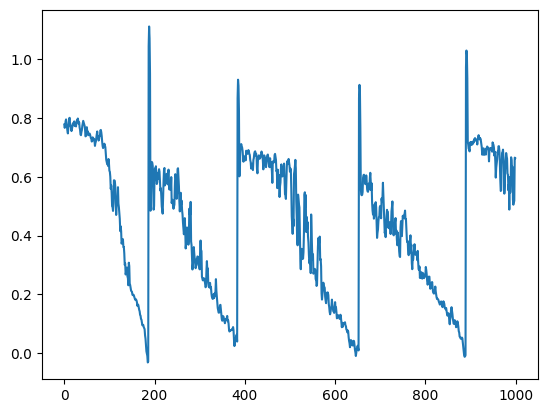

In [ ]:
plt.plot(y_pred.flatten()[:1000]);

In [ ]:
y_train_pred = y_train_pred.flatten()
y_pred = y_pred.flatten()

In [ ]:
ze = np.zeros(4,)
y_train_pred = np.concatenate((ze,y_train_pred), axis=0)
y_train_pred.shape

(41456,)

In [ ]:
ze = np.zeros(4,)
y_pred = np.concatenate((ze,y_pred), axis=0)
y_pred.shape

(12303,)

In [ ]:
HItrain_df['apprx_HI_CNN'] = y_train_pred
HIval_df['apprx_HI_CNN'] = y_pred

In [ ]:
HItrain_df.to_csv('HItrain_df')
HIval_df.to_csv('HIval_df')

Comment: With the CNN, time window of 5 we were able to reduce the error from 0.23 to 0.0190. I almost missed it,and the rscore from 0.72 to 0.77. But we still need more, we need a rscore of around 90% so more sophisticated models will be used next.

# Attention Network.